In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
df = pd.read_csv('cicids2017_COMBINED.csv', sep='\t', engine='python')

In [38]:
df

,Unnamed: 0,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,54865,3,2,0,12,0,6,6,6.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,1,55054,109,1,1,6,6,6,6,6.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,2,55055,52,1,1,6,6,6,6,6.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,3,46236,34,1,1,6,6,6,6,6.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,4,54863,3,2,0,12,0,6,6,6.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,692698,53,32215,4,2,112,152,28,28,28.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,692699,53,324,2,2,84,362,42,42,42.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,692700,58030,82,2,1,31,6,31,0,15.5,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,692701,53,1048635,6,2,192,256,32,32,32.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [39]:
df.columns

Index(['Unnamed: 0', ' Destination Port', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Lengt

In [40]:
df.shape

(2830743, 80)

# Data Cleaning

In [41]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(2830743, 79)

In [43]:
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

Features with at least one NaN or Infinity value:
Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64


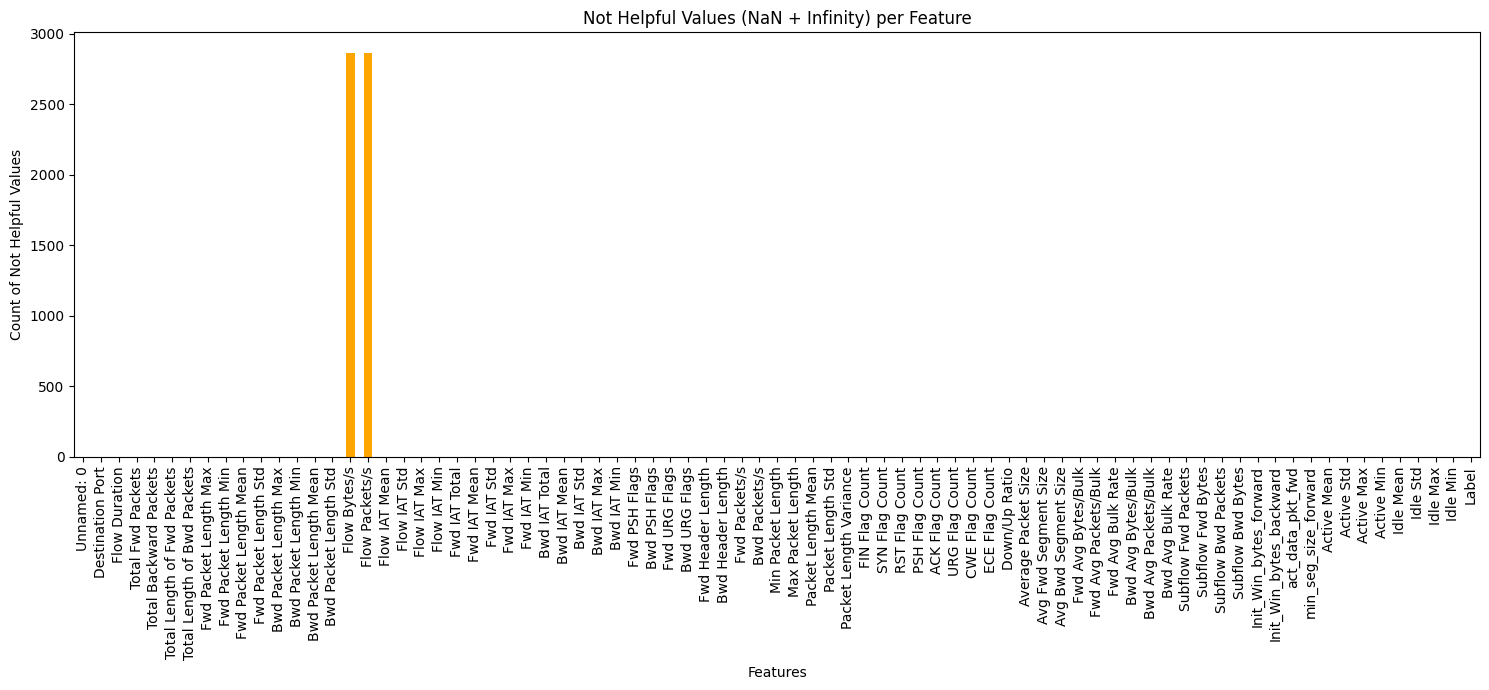

In [44]:
nan_counts = df.isna().sum()
def count_infs(col):
    if pd.api.types.is_numeric_dtype(col):
        return np.isinf(col).sum()
    else:
        return 0
inf_counts = df.apply(count_infs)
not_helpful_counts = nan_counts + inf_counts
features_with_issue = not_helpful_counts[not_helpful_counts > 0]
print("Features with at least one NaN or Infinity value:")
print(features_with_issue)
plt.figure(figsize=(15, 7))
not_helpful_counts.plot(kind='bar', color='orange')
plt.title("Not Helpful Values (NaN + Infinity) per Feature")
plt.xlabel("Features")
plt.ylabel("Count of Not Helpful Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [46]:
# Checking for infinite values
num_columns = df.select_dtypes(include = np.number).columns
has_infinite = np.isinf(df[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64


In [47]:
# Treating infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [48]:
# Attack counts
attack_counts = df['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = df.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2273097,2271320,1777,0.08
1,DoS Hulk,231073,230124,949,0.41
2,PortScan,158930,158804,126,0.08
3,DDoS,128027,128025,2,0.00
4,DoS GoldenEye,10293,10293,0,0.00
5,FTP-Patator,7938,7935,3,0.04
6,SSH-Patator,5897,5897,0,0.00
7,DoS slowloris,5796,5796,0,0.00
8,DoS Slowhttptest,5499,5499,0,0.00
9,Bot,1966,1956,10,0.51


In [49]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [50]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = df.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.830743e+06
mean     2.564072e-03
std      8.052794e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.531646e+00
dtype: float64

Total rows with missing values: 2867


In [51]:
# Dropping missing values
df = df.dropna()
print(f'Dataset shape after row-wise removal: {df.shape}')

Dataset shape after row-wise removal: (2827876, 79)


In [52]:
nan_counts = df.isna().sum()
inf_counts = df.apply(count_infs)
print("Features with NaNs")
print(nan_counts[nan_counts>0])
print("Features with Infs")
print(inf_counts[inf_counts>0])

Features with NaNs
Series([], dtype: int64)
Features with Infs
Series([], dtype: int64)


In [53]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

[]

In [54]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))
df['Label'].value_counts()

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [55]:
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

In [56]:
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"Without duplicate rows shape: {df.shape}")

Original shape: (2827876, 79)
Without duplicate rows shape: (2827864, 79)


In [62]:
identical_columns = {}
columns = df.columns
list_control = columns.copy().tolist()

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if df[col1].equals(df[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

No identical columns found.


In [ ]:
for key, value in identical_columns.items():
    df.drop(columns=value, inplace=True)

In [61]:
df.columns

Index(['Unnamed: 0', 'Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
    

In [59]:
df.shape

(2827864, 68)

In [64]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')


Bwd PSH Flags

The number of columns with only one unique values is: 1


In [66]:
# Dropping the columns with only one unique value
df.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [68]:
df.shape


(2827864, 67)

In [69]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
df['Attack Type'] = df['Label'].map(group_mapping)

In [72]:
print(df['Attack Type'].value_counts())
df.drop(columns='Label', inplace=True)

Attack Type
Normal Traffic    2271308
DoS                251712
Port Scanning      158804
DDoS               128025
Brute Force         13832
Web Attacks          2180
Bots                 1956
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64


In [73]:
# Removing rows with statistically irrelevant attack types
df.drop(df[(df['Attack Type'] == 'Infiltration') | (df['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [75]:
# Data shape and attack counts after removal
print(df.shape)
df['Attack Type'].value_counts()

(2827817, 67)


Attack Type
Normal Traffic    2271308
DoS                251712
Port Scanning      158804
DDoS               128025
Brute Force         13832
Web Attacks          2180
Bots                 1956
Name: count, dtype: int64

# Correlation Analysis

In [82]:
import seaborn as sns

In [ ]:
def get_feature_types(df, target_col='Attack Type'):
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [ ]:
def correlation_analysis(df, numeric_features, threshold=0.85):
    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

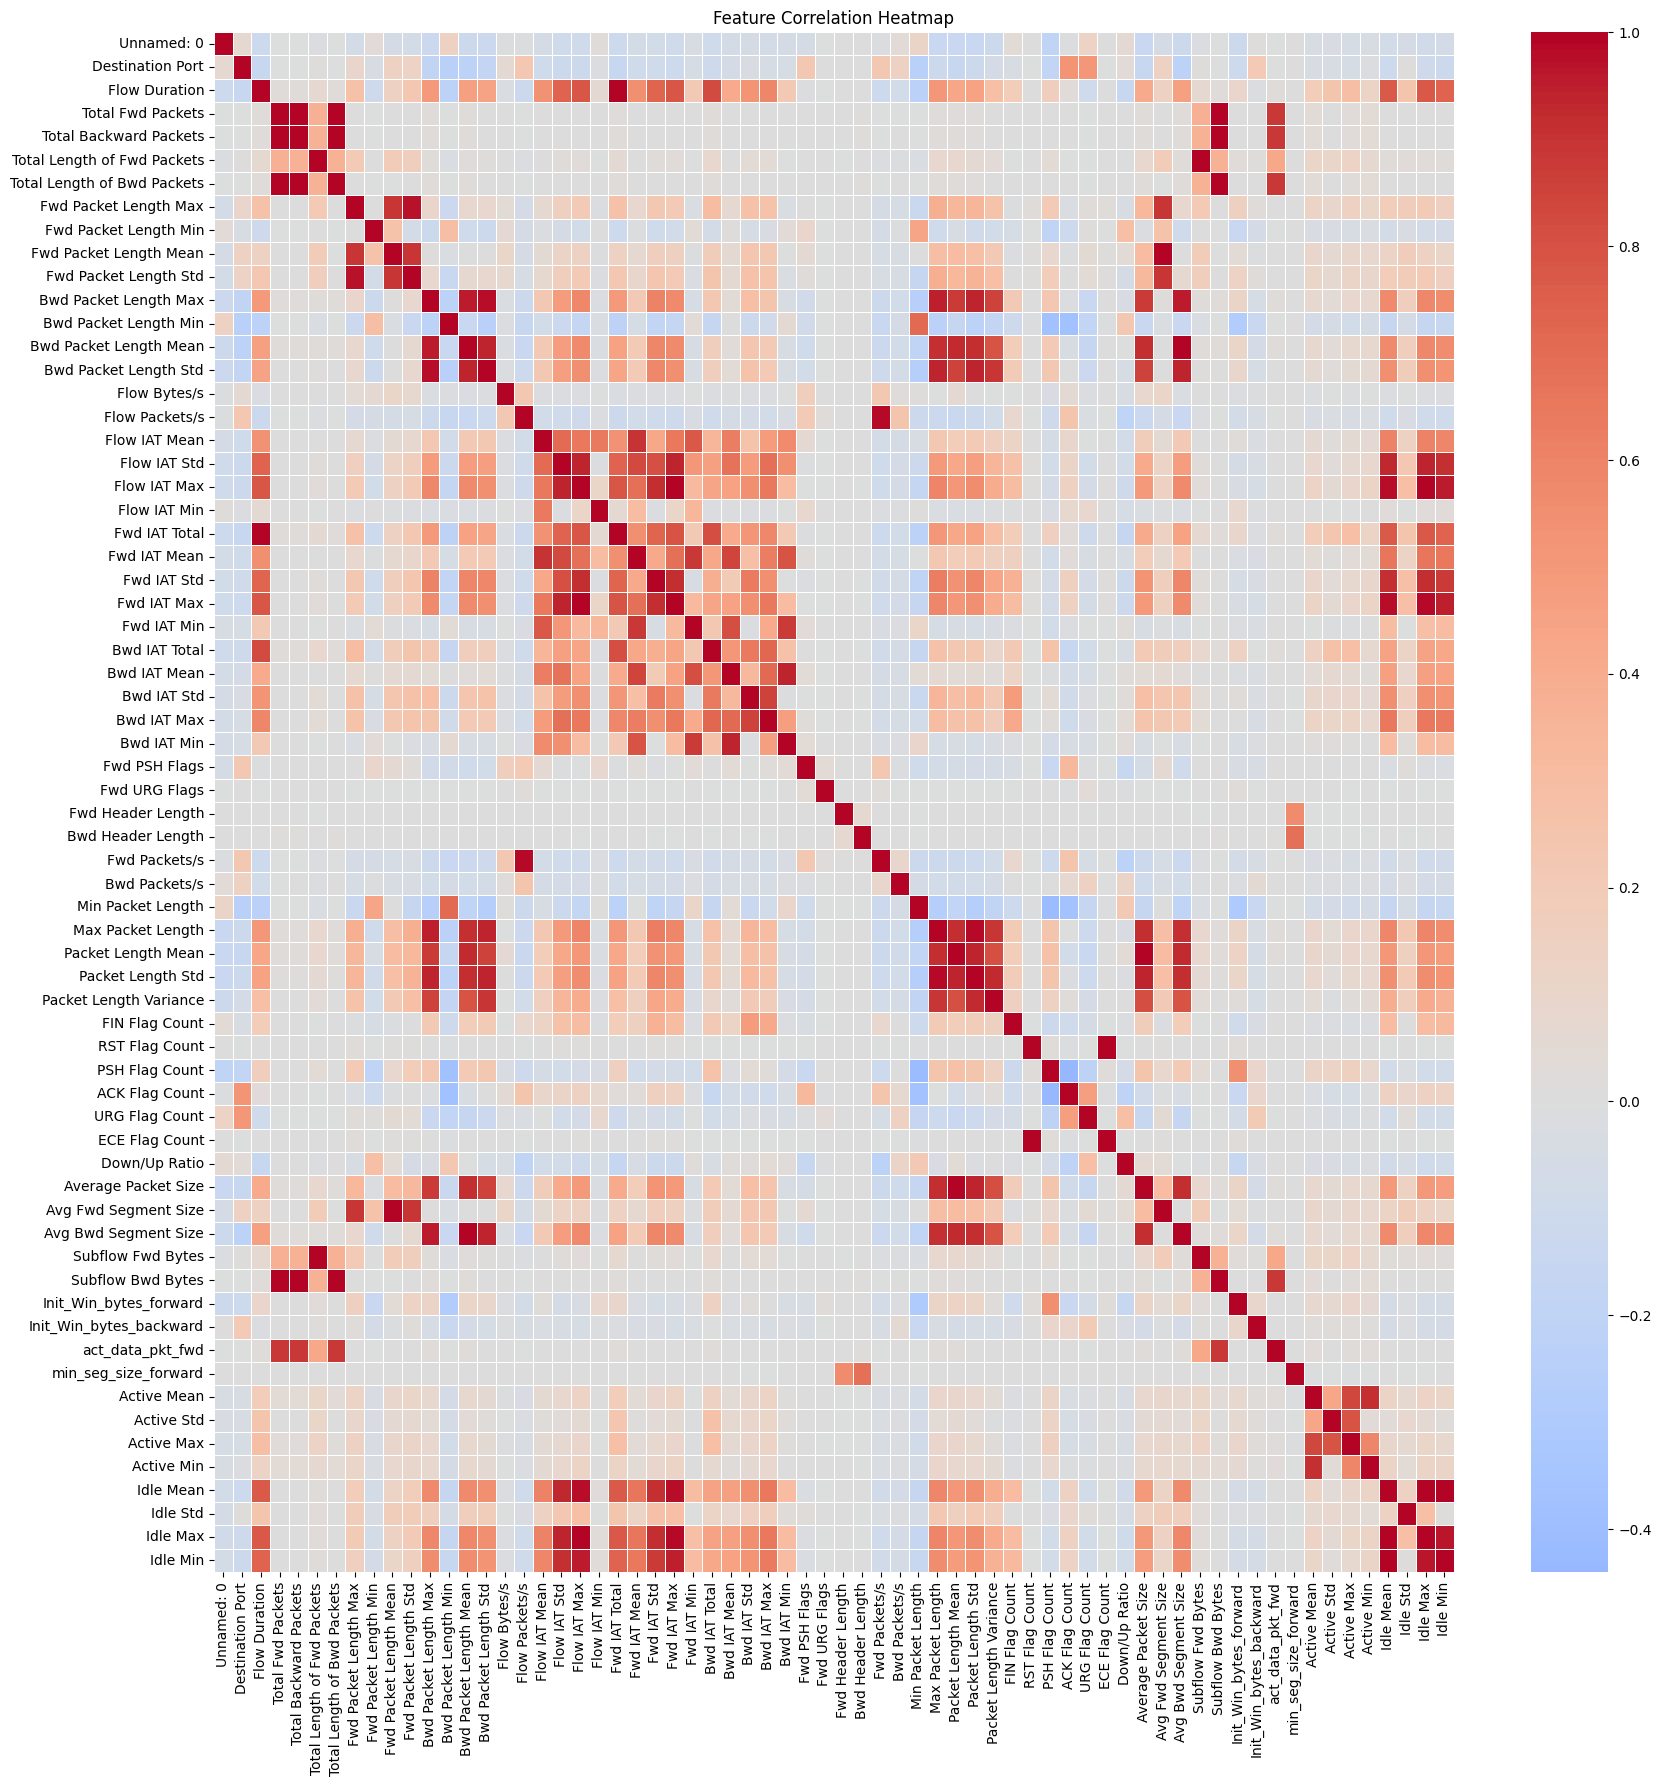

In [83]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df)
high_corr = correlation_analysis(df, numeric_features)

In [84]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9986
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.8876
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.96

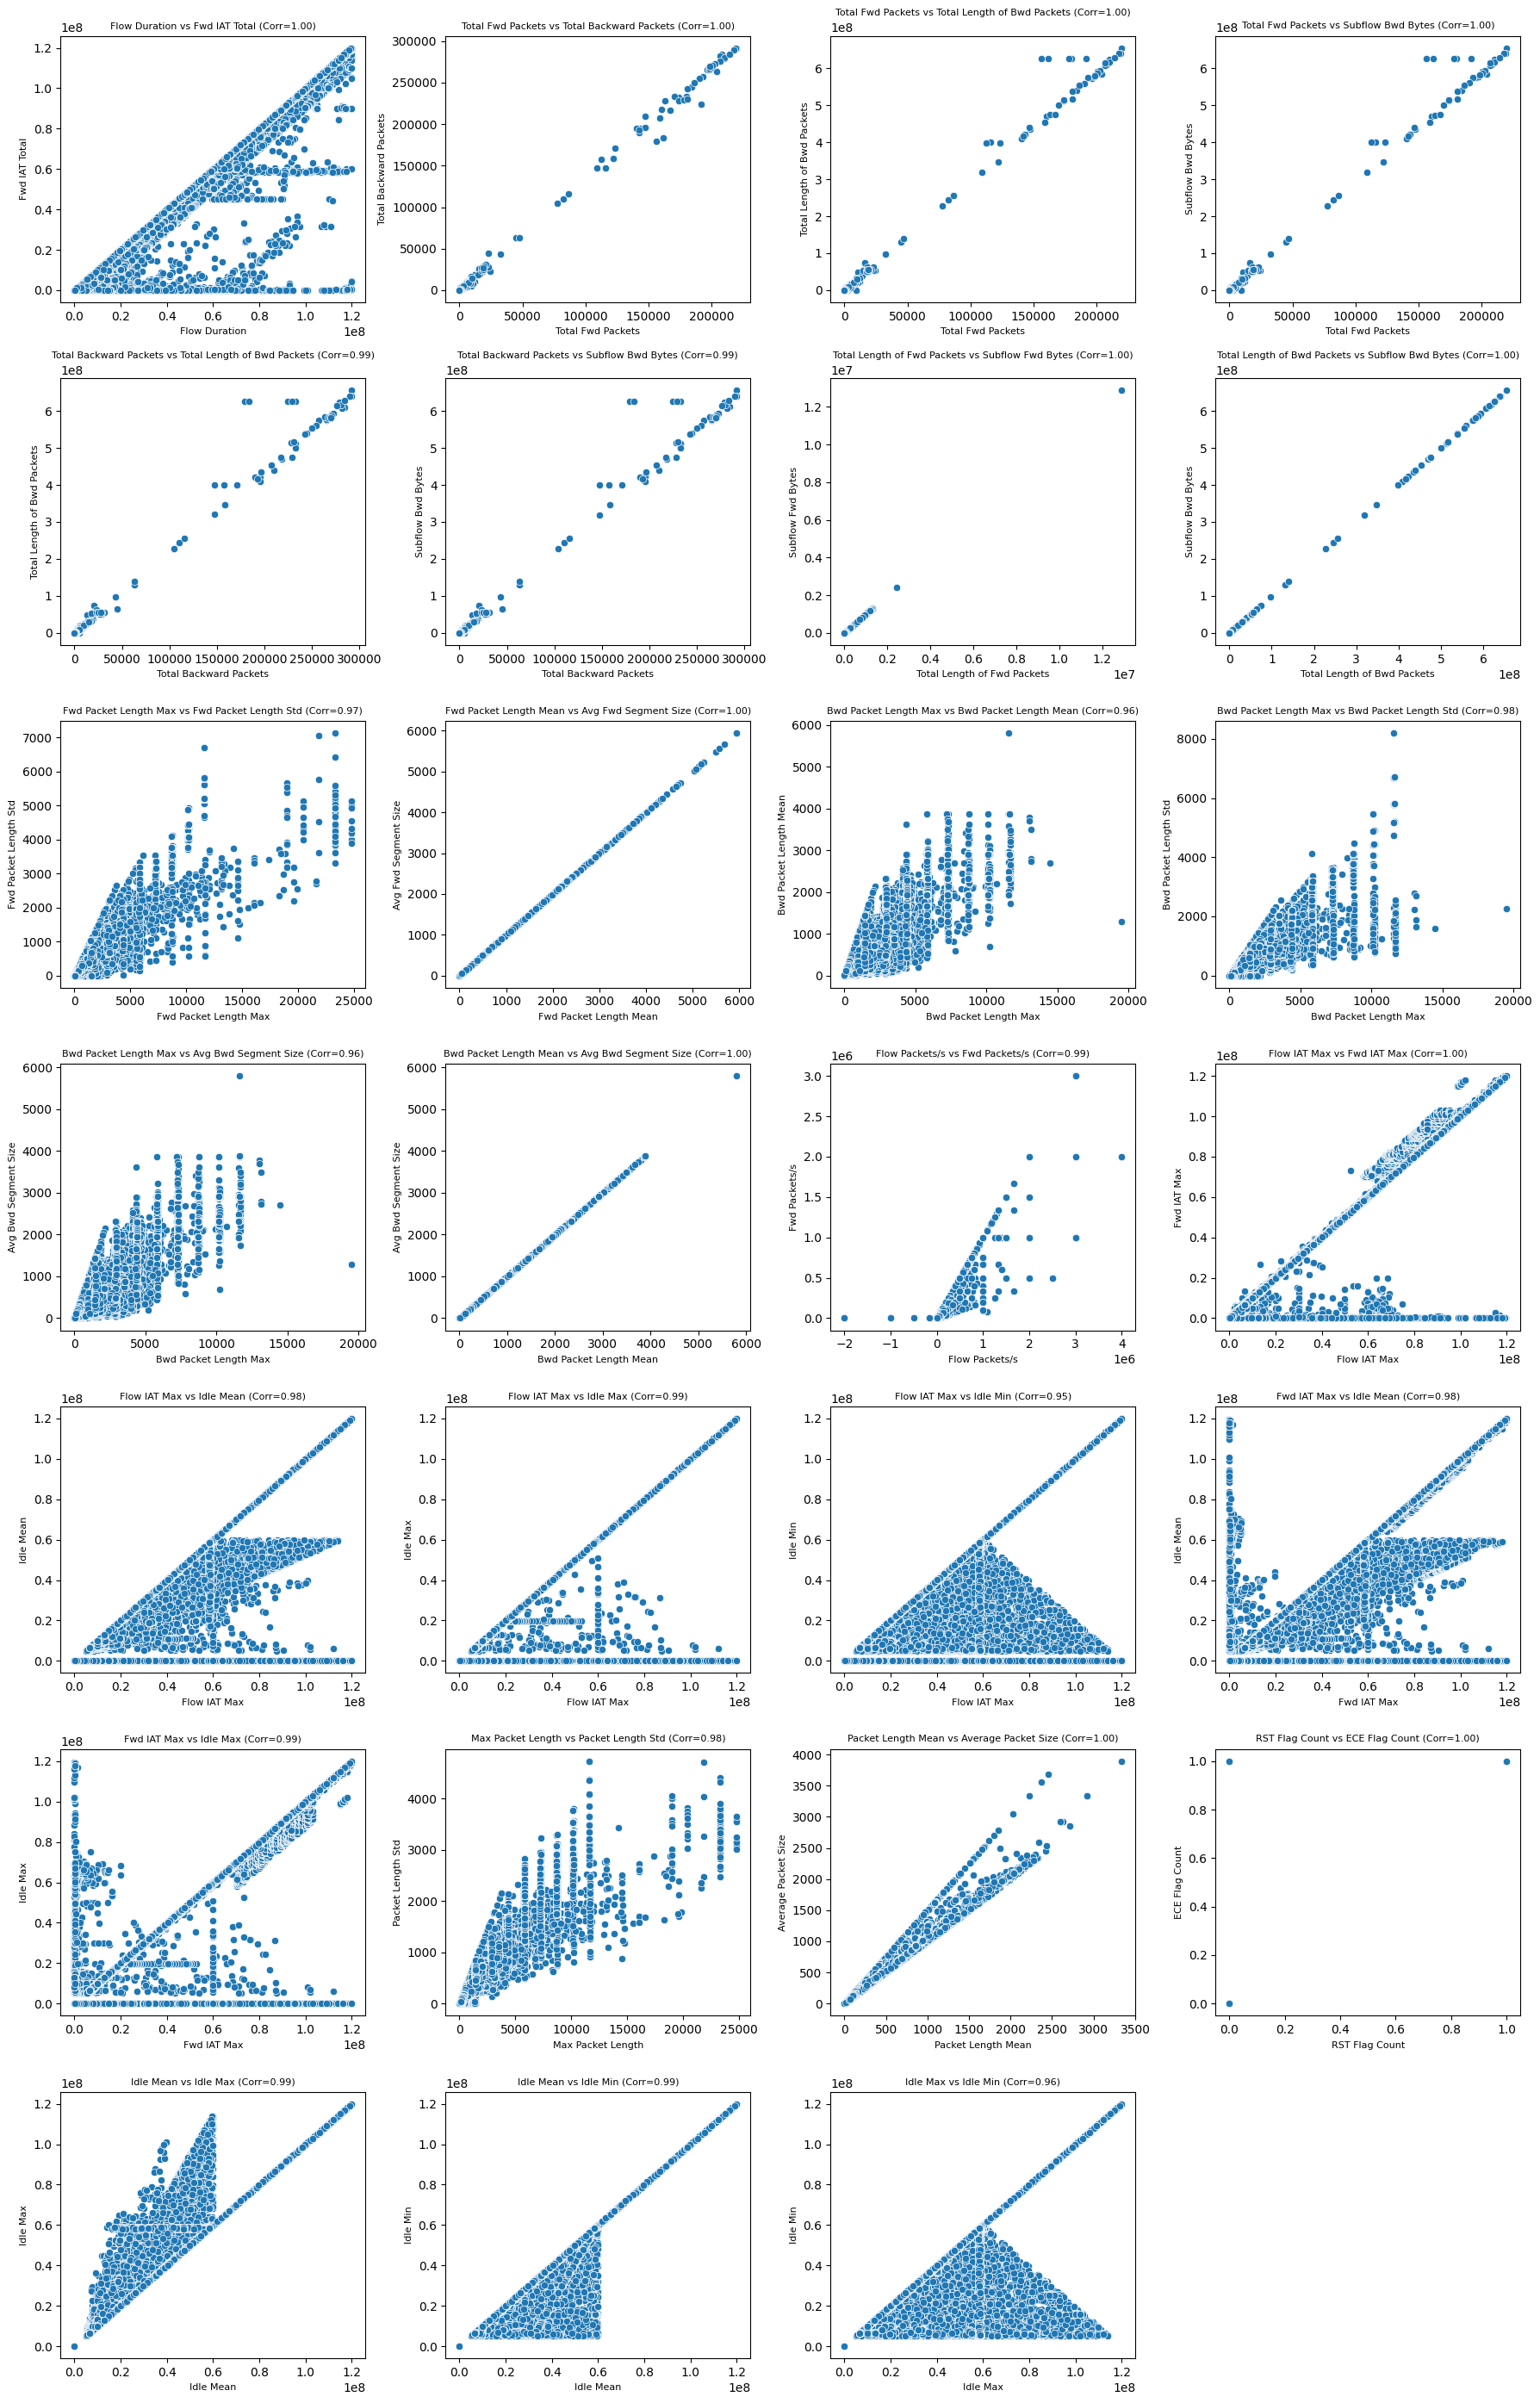

In [86]:
# Plotting the pairs with very high correlation for better visualization
n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=df[feature_x], y=df[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [87]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
df.drop(columns=selected_columns, inplace=True)

In [95]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(df)
df.shape

(2827817, 61)

## Outliers

In [97]:
def calculate_outliers_percentage(df):
    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

<Figure size 1500x1000 with 0 Axes>

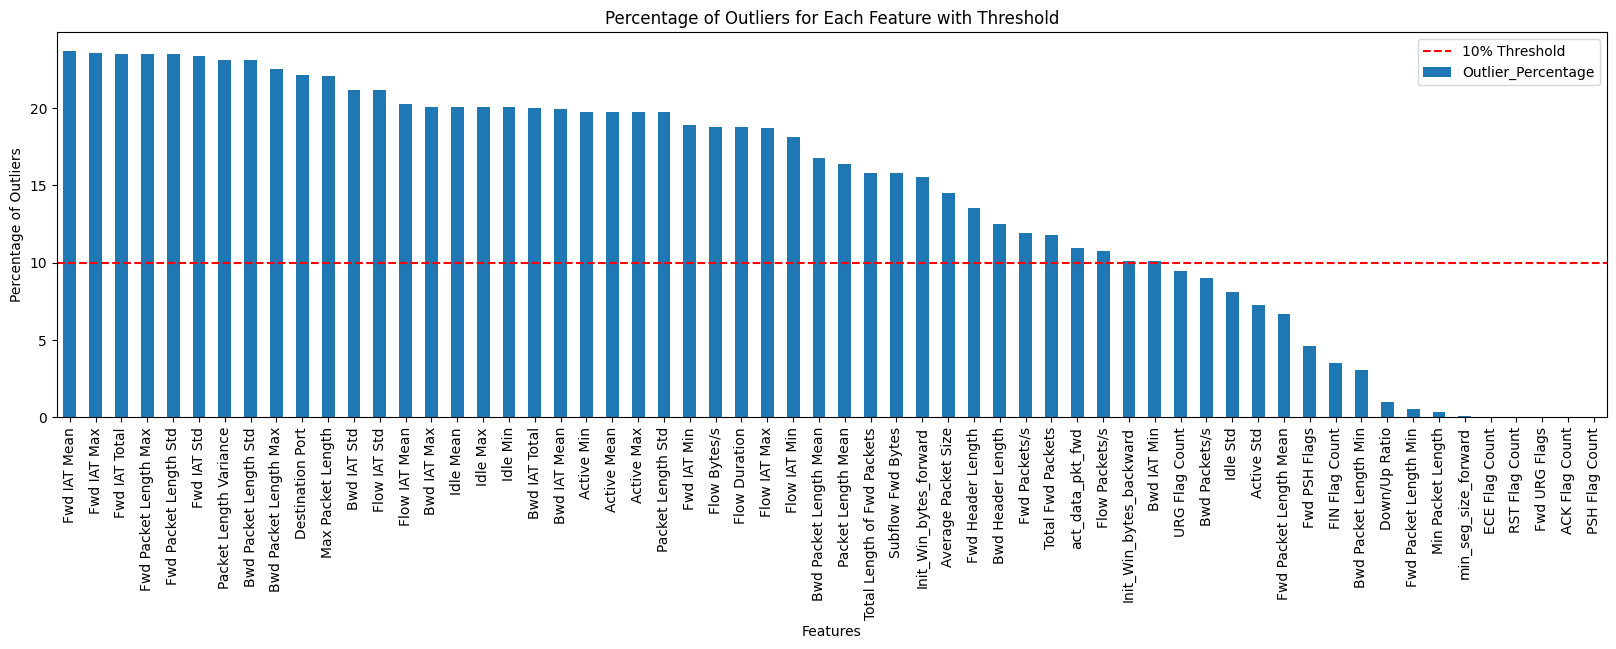

In [98]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(df[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [106]:
# Print the features with high outlier percentages
print(f"Features with outlier percentage above {threshold}%:\n")
print(high_outlier_features.sort_values('Outlier_Percentage', ascending=False))


Features with outlier percentage above 10%:

                             Outlier_Percentage
Fwd IAT Mean                          23.717093
Fwd IAT Max                           23.533418
Fwd IAT Total                         23.521748
Fwd Packet Length Max                 23.487022
Fwd Packet Length Std                 23.478111
Fwd IAT Std                           23.338568
Packet Length Variance                23.129361
Bwd Packet Length Std                 23.125860
Bwd Packet Length Max                 22.526493
Destination Port                      22.136015
Max Packet Length                     22.045521
Bwd IAT Std                           21.176476
Flow IAT Std                          21.150025
Flow IAT Mean                         20.250037
Bwd IAT Max                           20.080720
Idle Mean                             20.059820
Idle Max                              20.059820
Idle Min                              20.059820
Bwd IAT Total                         19.98